# Instalacja zależności

Praca Licencjacka 2025 – instalacja wymaganych bibliotek.

In [4]:
#%pip install -r requirements.txt

# Import bibliotek

Importujemy wszystkie niezbędne biblioteki do analizy, wizualizacji i modelowania.

In [5]:
import pandas as pd              # operacje na danych
import numpy as np               # operacje matematyczne
import matplotlib.pyplot as plt  # wykresy
import seaborn as sns            # zaawansowane wizualizacje

from scipy.stats import shapiro, spearmanr, jarque_bera, anderson, normaltest  # testy statystyczne
from sklearn.linear_model import LinearRegression  # regresja liniowa
import statsmodels.api as sm     # modelowanie statystyczne
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy                     # obróbka formuł
import stargazer                 # prezentacja wyników
import scipy.stats as stats      # dodatkowe testy i wykresy QQ

# Wczytanie i eksploracja danych

Wczytujemy dane z pliku Excel, dokonujemy wstępnej eksploracji i filtrujemy obserwacje.

In [6]:
# Wczytanie danych
data_path = "Model_Lekarz.xlsx"
data = pd.read_excel(data_path)
print(data.head())
print(data.info())

   nr_gosp  plec  wiek  wyksz  inwalidztwo  liczba_osob  doch_calkowity   \
0       13     1    61      2            2            3          4820.00   
1       16     2    24      2            2            2          2563.00   
2       28     1    79      3            2            2          4084.68   
3       32     2    58      3            2            2          3971.00   
4       33     1    69      2            2            2          5020.00   

   klasa_miejsca  syt_mat      doch_os  wyd_calkowite  glowne_zrod_utrzym  \
0              1        3  1606.666667        5089.05                   4   
1              1        3  1281.500000        2291.80                   5   
2              1        1  2042.340000        5842.62                   5   
3              3        1  1985.500000        4553.61                   3   
4              3        3  2510.000000        2539.88                   4   

   moz_oszcz     R5  wyd_os_lek  
0          2  300.0       100.0  
1          4

# Czyszczenie danych i przekształcenia

Przypisujemy kategorie oraz etykiety dla kolumn i filtrujemy dane (zachowujemy tylko obserwacje, gdzie 'wyd_os_lek' > 0).

In [7]:
## Przypisywanie kategorii
data['miejscowosc'] = pd.Categorical(data['klasa_miejsca'], 
                                     categories=[1, 2, 3, 4, 5, 6], 
                                     ordered=True)
data['miejscowosc'] = data['miejscowosc'].cat.rename_categories([
    "powyzej 500 tys", "200-499 tys", "100-199 tys", "20-99 tys", "ponizej 20 tys", "wies"
])

data['wyksztalcenie_1'] = pd.Categorical(data['wyksz'], 
                                       categories=[1, 2, 3], 
                                       ordered=True)
data['wyksztalcenie_1'] = data['wyksztalcenie_1'].cat.rename_categories([
    "podstawowe", "srednie", "wyzsze"
])

data['mozliwosci_oszczedzania_1'] = pd.Categorical(data['moz_oszcz'], 
                                                 categories=[1, 2, 3, 4], 
                                                 ordered=True)
data['mozliwosci_oszczedzania_1'] = data['mozliwosci_oszczedzania_1'].cat.rename_categories([
    "regularnie", "nieregularnie", "mozemy_ale_nie", "nie_mozemy"
])

data['zrodlo_utrzymania_1'] = pd.Categorical(data['glowne_zrod_utrzym'], 
                                           categories=[1, 2, 3, 4, 5], 
                                           ordered=True)
data['zrodlo_utrzymania_1'] = data['zrodlo_utrzymania_1'].cat.rename_categories([
    "pracownicy", "rolnicy", "praca na wlasny rachunek", "emeryt/rencista", "niezarobkowe zrodla dochodu"
])

data['sytuacja_materialna_1'] = pd.Categorical(data['syt_mat'], 
                                             categories=[1, 2, 3, 4, 5], 
                                             ordered=True)
data['sytuacja_materialna_1'] = data['sytuacja_materialna_1'].cat.rename_categories([
    "dobra", "raczej dobra", "przecietna", "raczej zla", "zla"
])

## Filtrowanie obserwacji
model2 = data[data['wyd_os_lek'] > 0].copy()
print(model2.head())

   nr_gosp  plec  wiek  wyksz  inwalidztwo  liczba_osob  doch_calkowity   \
0       13     1    61      2            2            3          4820.00   
1       16     2    24      2            2            2          2563.00   
2       28     1    79      3            2            2          4084.68   
3       32     2    58      3            2            2          3971.00   
4       33     1    69      2            2            2          5020.00   

   klasa_miejsca  syt_mat      doch_os  wyd_calkowite  glowne_zrod_utrzym  \
0              1        3  1606.666667        5089.05                   4   
1              1        3  1281.500000        2291.80                   5   
2              1        1  2042.340000        5842.62                   5   
3              3        1  1985.500000        4553.61                   3   
4              3        3  2510.000000        2539.88                   4   

   moz_oszcz     R5  wyd_os_lek      miejscowosc wyksztalcenie_1  \
0          2

# Wizualizacje i raportowanie

Tworzymy wykresy: histogramy, boxploty, wykresy rozrzutu oraz macierz korelacji.

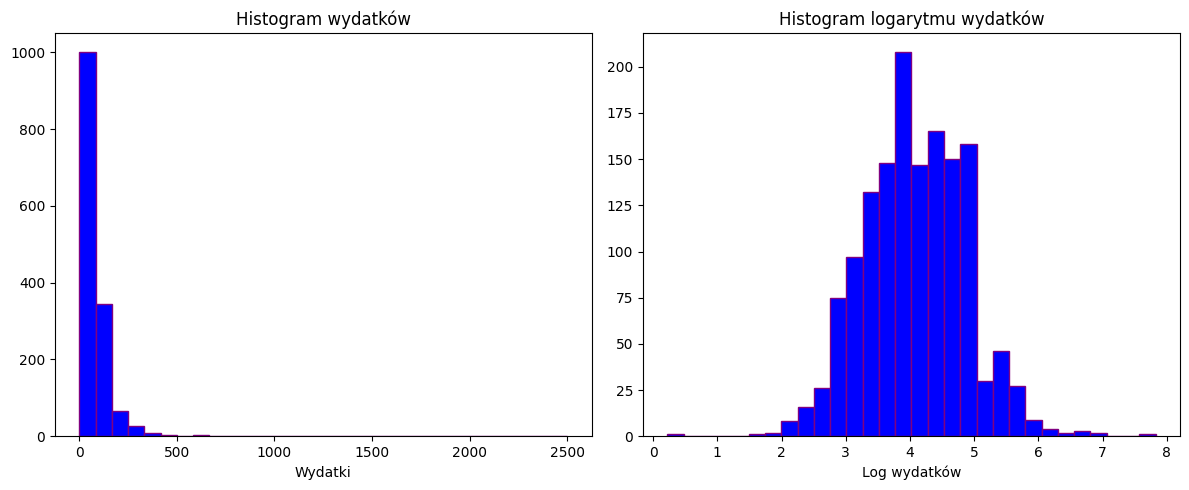

In [8]:
## Histogramy wydatków
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram wydatków
ax1.hist(model2['wyd_os_lek'], bins=30, color='blue', edgecolor='purple')
ax1.set_xlabel('Wydatki')
ax1.set_title('Histogram wydatków')

# Histogram logarytmu wydatków
ax2.hist(np.log(model2['wyd_os_lek']), bins=30, color='blue', edgecolor='purple')
ax2.set_xlabel('Log wydatków')
ax2.set_title('Histogram logarytmu wydatków')

plt.tight_layout()
plt.show()

In [9]:
## Statystyczne podsumowanie wydatków
summary_wydatki_los = model2['wyd_os_lek'].describe()
print(summary_wydatki_los)

count    1458.000000
mean       82.184822
std       104.253813
min         1.250000
25%        35.000000
50%        60.000000
75%       100.000000
max      2500.000000
Name: wyd_os_lek, dtype: float64


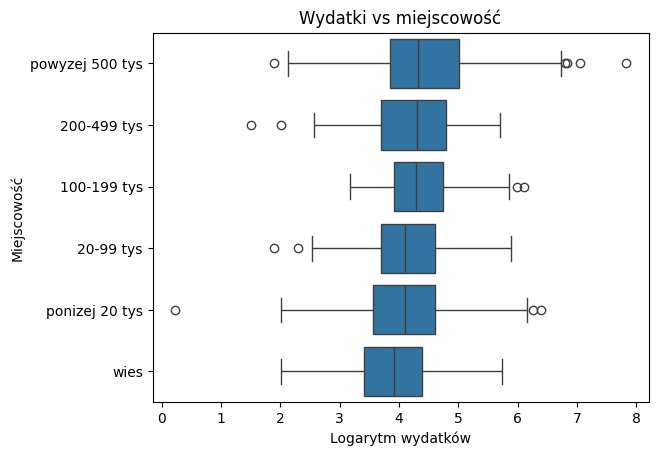

                 count        mean         std        min        25%  \
miejscowosc                                                            
powyzej 500 tys  273.0  127.750409  199.650406   6.666667  46.666667   
200-499 tys       87.0   85.220307   60.614204   4.500000  40.000000   
100-199 tys       54.0  100.552469   87.901423  24.000000  50.000000   
20-99 tys        234.0   78.877350   59.517174   6.666667  40.000000   
ponizej 20 tys   168.0   85.311012   85.419254   1.250000  35.000000   
wies             642.0   61.239968   45.941622   7.500000  30.000000   

                       50%      75%     max  
miejscowosc                                  
powyzej 500 tys  75.000000  150.000  2500.0  
200-499 tys      73.333333  120.000   300.0  
100-199 tys      72.500000  115.000   450.0  
20-99 tys        60.000000  100.000   360.0  
ponizej 20 tys   60.000000  100.000   600.0  
wies             50.000000   79.625   310.0  


In [10]:
## Boxplot: Wydatki vs Miejscowość
sns.boxplot(y=model2['miejscowosc'], x=np.log(model2['wyd_os_lek']), orient='h')
plt.title('Wydatki vs miejscowość')
plt.xlabel('Logarytm wydatków')
plt.ylabel('Miejscowość')
plt.show()

summary_miejscowosc = model2.groupby('miejscowosc', observed=False)['wyd_os_lek'].describe()
print(summary_miejscowosc)

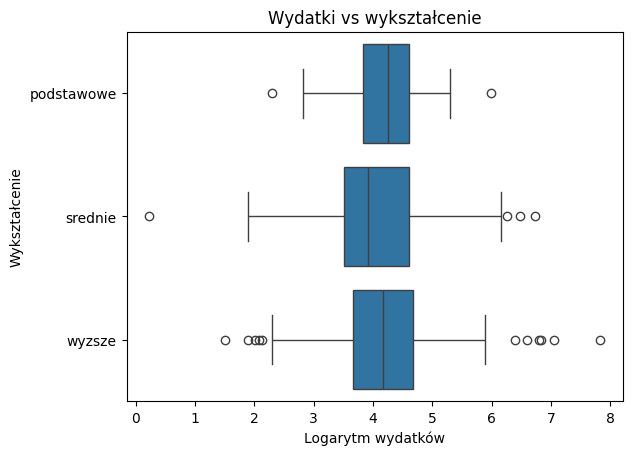

                 count       mean         std    min        25%   50%    75%  \
wyksztalcenie_1                                                                
podstawowe       143.0  78.660306   52.483750  10.00  45.833333  70.0  100.0   
srednie          840.0  75.212880   72.736347   1.25  33.333333  50.0  100.0   
wyzsze           475.0  95.575218  151.491955   4.50  38.750000  65.0  107.0   

                    max  
wyksztalcenie_1          
podstawowe        400.0  
srednie           830.0  
wyzsze           2500.0  


In [11]:
## Boxplot: Wydatki vs Wykształcenie
sns.boxplot(y=model2['wyksztalcenie_1'], x=np.log(model2['wyd_os_lek']), orient='h')
plt.title('Wydatki vs wykształcenie')
plt.xlabel('Logarytm wydatków')
plt.ylabel('Wykształcenie')
plt.show()

summary_wyksztalcenie = model2.groupby('wyksztalcenie_1', observed=False)['wyd_os_lek'].describe()
print(summary_wyksztalcenie)

In [12]:
## Test Kruskala-Wallisa dla wykształcenia
from scipy.stats import kruskal

podstawowe = model2[model2['wyksztalcenie_1'] == 'podstawowe']['wyd_os_lek']
srednie = model2[model2['wyksztalcenie_1'] == 'srednie']['wyd_os_lek']
wyzsze = model2[model2['wyksztalcenie_1'] == 'wyzsze']['wyd_os_lek']

stat, p = kruskal(podstawowe, srednie, wyzsze)
print(f"Wartość statystyki H = {stat:.4f}")
print(f"Wartość p = {p:.4f}")
if p < 0.05:
    print("Różnice pomiędzy grupami są statystycznie istotne (p < 0.05).")
else:
    print("Brak istotnych statystycznie różnic pomiędzy grupami.")

Wartość statystyki H = 17.0421
Wartość p = 0.0002
Różnice pomiędzy grupami są statystycznie istotne (p < 0.05).


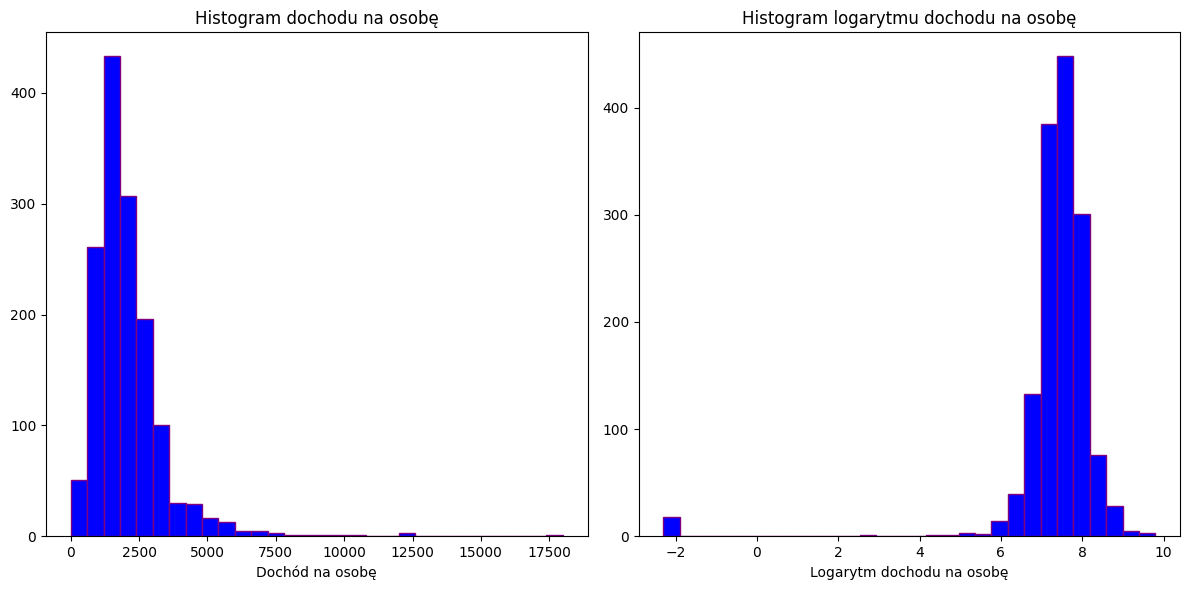

In [13]:
## Histogram dochodu
model2['dochod_los'] = model2['doch_os'].apply(lambda x: 0.1 if (x == 0 or x < 0) else x)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(model2['dochod_los'], bins=30, color='blue', edgecolor='purple')
ax[0].set_title('Histogram dochodu na osobę')
ax[0].set_xlabel('Dochód na osobę')

ax[1].hist(np.log(model2['dochod_los']), bins=30, color='blue', edgecolor='purple')
ax[1].set_title('Histogram logarytmu dochodu na osobę')
ax[1].set_xlabel('Logarytm dochodu na osobę')

plt.tight_layout()
plt.show()

In [14]:
## Tworzenie zmiennych przekształconych
model2['log_dochod'] = np.log(model2['dochod_los'])
model2['log_dochod_kwadrat'] = model2['log_dochod'] ** 2

In [15]:
## Prosty model regresji na wydatkach
model = smf.ols('wyd_os_lek ~ log_dochod + log_dochod_kwadrat', data=model2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             wyd_os_lek   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     64.03
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.23e-27
Time:                        00:22:30   Log-Likelihood:                -8781.9
No. Observations:                1458   AIC:                         1.757e+04
Df Residuals:                    1455   BIC:                         1.759e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -15.4865     16

In [16]:
## Podsumowanie dochodu
summary_dochod_los = model2['doch_os'].describe()
print(summary_dochod_los)

count     1458.000000
mean      2054.386052
std       1346.060933
min      -3416.800000
25%       1281.248750
50%       1788.484333
75%       2500.000000
max      18000.000000
Name: doch_os, dtype: float64


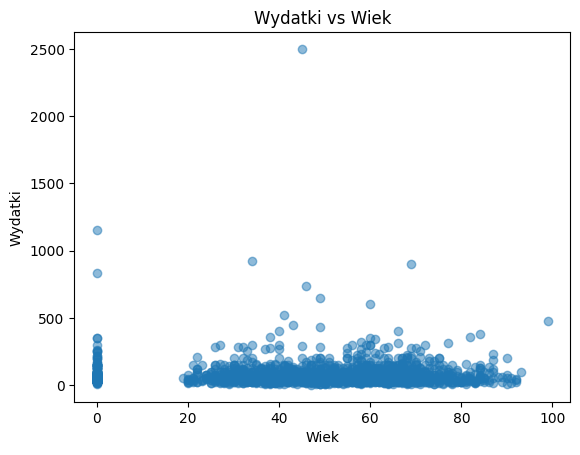

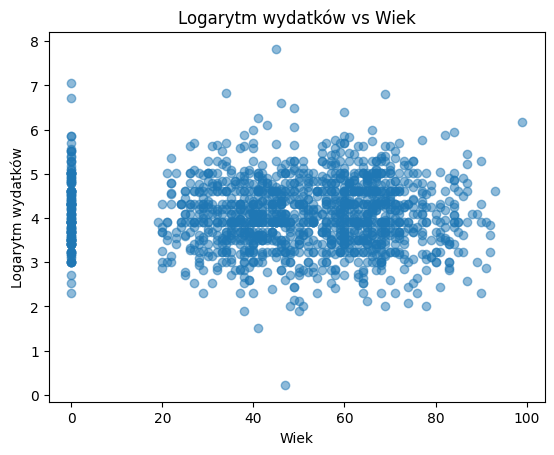

In [17]:
## Wykresy rozrzutu: Wydatki vs Wiek
plt.scatter(model2['wiek'], model2['wyd_os_lek'], alpha=0.5)
plt.title('Wydatki vs Wiek')
plt.xlabel('Wiek')
plt.ylabel('Wydatki')
plt.show()

plt.scatter(model2['wiek'], np.log(model2['wyd_os_lek']), alpha=0.5)
plt.title('Logarytm wydatków vs Wiek')
plt.xlabel('Wiek')
plt.ylabel('Logarytm wydatków')
plt.show()

# Modelowanie statystyczne

Tworzymy modele regresji, diagnozujemy wpływ obserwacji odstających oraz analizujemy nieliniowość i heteroskedastyczność.

In [18]:
## Tworzenie zmiennych zero-jedynkowych (dummy) dla dalszego modelowania
# Wykształcenie
model2['wyzsze'] = model2['wyksz'].apply(lambda x: 1 if x == 3 else 0)
model2['srednie'] = model2['wyksz'].apply(lambda x: 1 if x == 2 else 0)
model2['podstawowe'] = model2['wyksz'].apply(lambda x: 1 if x == 1 else 0)
print(model2[['wyzsze', 'srednie', 'podstawowe']].sum())

# Miasto
model2['powyzej500tys'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 1 else 0)
model2['od200do499'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 2 else 0)
model2['od100do199'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 3 else 0)
model2['od20do99'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 4 else 0)
model2['ponizej20'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 5 else 0)
model2['wies'] = model2['klasa_miejsca'].apply(lambda x: 1 if x == 6 else 0)
print(model2[['powyzej500tys', 'od200do499', 'od100do199', 'od20do99', 'ponizej20', 'wies']].sum())

# Możliwości oszczędzania
model2['regularnie'] = model2['moz_oszcz'].apply(lambda x: 1 if x == 1 else 0)
model2['nieregularnie'] = model2['moz_oszcz'].apply(lambda x: 1 if x == 2 else 0)
model2['mozemy_ale_nie'] = model2['moz_oszcz'].apply(lambda x: 1 if x == 3 else 0)
model2['nie_mozemy'] = model2['moz_oszcz'].apply(lambda x: 1 if x == 4 else 0)
print(model2[['regularnie', 'nieregularnie', 'mozemy_ale_nie', 'nie_mozemy']].sum())

# Sytuacja materialna
model2['dobra'] = model2['syt_mat'].apply(lambda x: 1 if x == 1 else 0)
model2['raczej_dobra'] = model2['syt_mat'].apply(lambda x: 1 if x == 2 else 0)
model2['przecietna'] = model2['syt_mat'].apply(lambda x: 1 if x == 3 else 0)
model2['raczej_zla'] = model2['syt_mat'].apply(lambda x: 1 if x == 4 else 0)
model2['zla'] = model2['syt_mat'].apply(lambda x: 1 if x == 5 else 0)
print(model2[['dobra', 'raczej_dobra', 'przecietna', 'raczej_zla', 'zla']].sum())

# Źródło utrzymania
model2['pracownicy'] = model2['glowne_zrod_utrzym'].apply(lambda x: 1 if x == 1 else 0)
model2['rolnicy'] = model2['glowne_zrod_utrzym'].apply(lambda x: 1 if x == 2 else 0)
model2['wlasny_rachunek'] = model2['glowne_zrod_utrzym'].apply(lambda x: 1 if x == 3 else 0)
model2['emeryt_rencista'] = model2['glowne_zrod_utrzym'].apply(lambda x: 1 if x == 4 else 0)
model2['niezarobkowe'] = model2['glowne_zrod_utrzym'].apply(lambda x: 1 if x == 5 else 0)
print(model2[['pracownicy', 'rolnicy', 'wlasny_rachunek', 'emeryt_rencista', 'niezarobkowe']].sum())

wyzsze        475
srednie       840
podstawowe    143
dtype: int64
powyzej500tys    273
od200do499        87
od100do199        54
od20do99         234
ponizej20        168
wies             642
dtype: int64
regularnie        329
nieregularnie     748
mozemy_ale_nie    110
nie_mozemy        271
dtype: int64
dobra           350
raczej_dobra    368
przecietna      674
raczej_zla       56
zla              10
dtype: int64
pracownicy         691
rolnicy             78
wlasny_rachunek    127
emeryt_rencista    531
niezarobkowe        31
dtype: int64


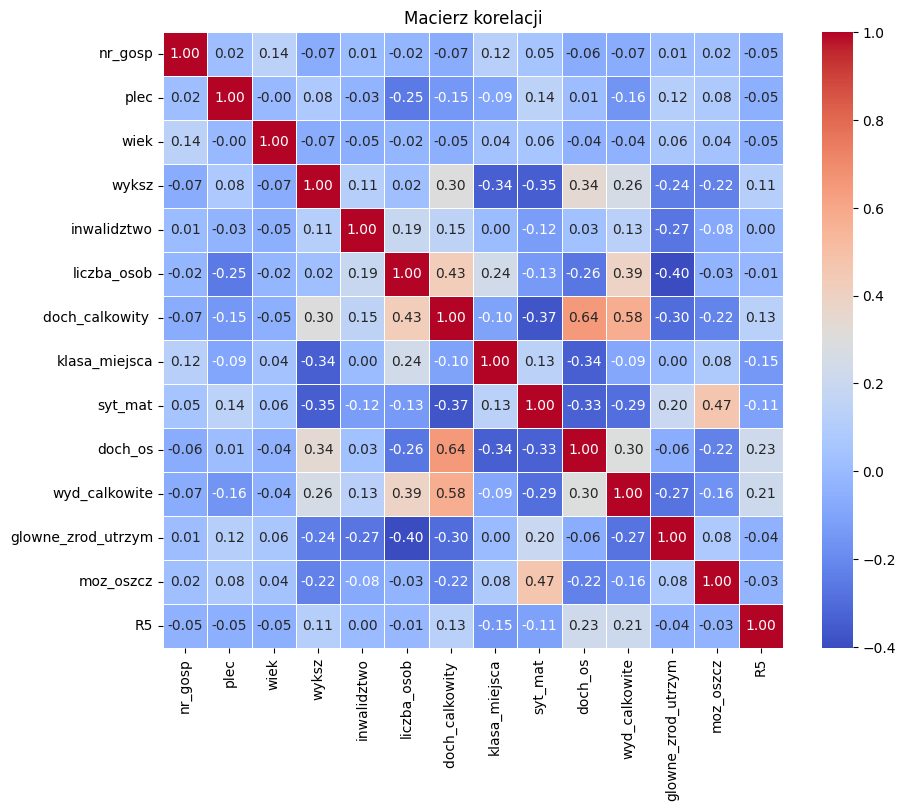

In [19]:
## Macierz korelacji
first_12_columns = model2.iloc[:, :14]
correlation_matrix = first_12_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Macierz korelacji')
plt.show()

In [20]:
## Model regresji (pełny model) – zmienna zależna: log_wydatki
model2['log_wydatki'] = model2['wyd_os_lek'].apply(lambda x: np.log(x) if x > 0 else np.nan)
formula_full = "log_wydatki ~ wiek + doch_os + wyzsze + srednie + powyzej500tys + od200do499 + od100do199 + od20do99 + ponizej20 + rolnicy + wlasny_rachunek + emeryt_rencista + niezarobkowe + liczba_osob + regularnie + nieregularnie + mozemy_ale_nie + plec + inwalidztwo"
reg_model2 = smf.ols(formula=formula_full, data=model2).fit()
print(reg_model2.summary())

                            OLS Regression Results                            
Dep. Variable:            log_wydatki   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     61.09
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          3.03e-169
Time:                        00:22:32   Log-Likelihood:                -1277.9
No. Observations:                1458   AIC:                             2596.
Df Residuals:                    1438   BIC:                             2701.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.9042      0.155     

## Diagnoza obserwacji odstających

Liczymy punkt zwrotny leverage, rysujemy wykres wpływu oraz usuwamy obserwacje odstające.

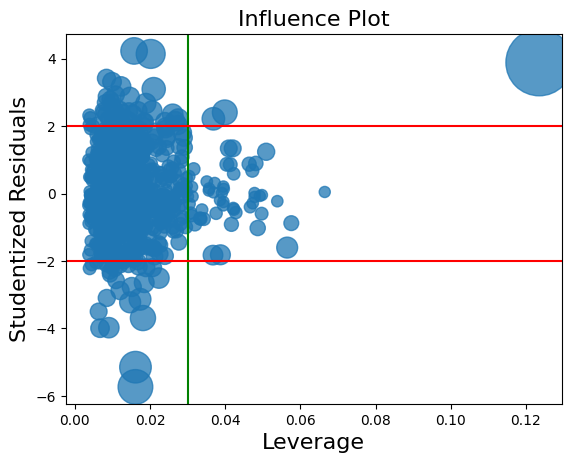

In [35]:
fig = sm.graphics.influence_plot(reg_model2, criterion='Cooks')
ax = fig.axes[0]
# Usunięcie wszystkich obiektów typu Text (etykiety)
for obj in ax.texts:
    obj.set_visible(False)

plt.axvline(x=round(h_lev, 2), color='g')
plt.axhline(y=2, color='r')
plt.axhline(y=-2, color='r')
plt.show()



In [22]:
# Usunięcie obserwacji odstających
model3 = model2.drop(index=[771, 975, 1169, 881, 740, 974, 842, 482, 943, 603])

In [23]:
## Model regresji z potęgowymi predyktorami (na model3)
model3['log_wydatki'] = model3['wyd_os_lek'].apply(lambda x: np.log(x) if x > 0 else np.nan)
model3['dochod_los'] = model3['doch_os'].apply(lambda x: 0.1 if (x == 0 or x < 0) else x)

formula_poly = "np.log(log_wydatki) ~ np.log(dochod_los) + wyzsze + srednie + powyzej500tys + od200do499 + od100do199 + od20do99 + ponizej20 + liczba_osob + I(liczba_osob**2) + I(liczba_osob**3) + inwalidztwo"
reg_2 = smf.ols(formula=formula_poly, data=model3).fit()
print(reg_2.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(log_wydatki)   R-squared:                       0.476
Model:                             OLS   Adj. R-squared:                  0.471
Method:                  Least Squares   F-statistic:                     108.6
Date:                 Mon, 14 Apr 2025   Prob (F-statistic):          2.05e-191
Time:                         00:22:36   Log-Likelihood:                 795.43
No. Observations:                 1448   AIC:                            -1565.
Df Residuals:                     1435   BIC:                            -1496.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [24]:
## Test reset dla modelu reg_2 oraz testy heteroskedastyczności
reset_test = sms.linear_reset(reg_2, power=4, test_type='fitted')
print("Reset test dla reg_2:", reset_test)

bp_test = sms.het_breuschpagan(reg_2.resid, reg_2.model.exog)
print("Breusch-Pagan test:", bp_test)

white_test = sms.het_white(reg_2.resid, reg_2.model.exog)
print("White test:", white_test)

Reset test dla reg_2: <Wald test (chi2): statistic=2.709230115482246, p-value=0.43866101119002265, df_denom=3>
Breusch-Pagan test: (np.float64(47.833489817867864), np.float64(3.341246030328118e-06), np.float64(4.085291367697863), np.float64(2.692375981383734e-06))
White test: (np.float64(103.68803241382594), np.float64(0.0034581848074056844), np.float64(1.5641698914335933), np.float64(0.002730358664386174))


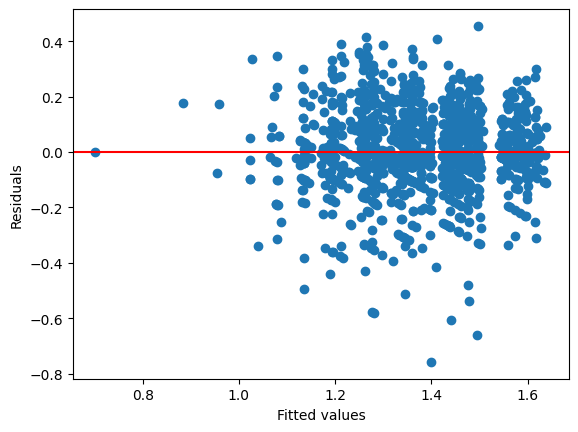

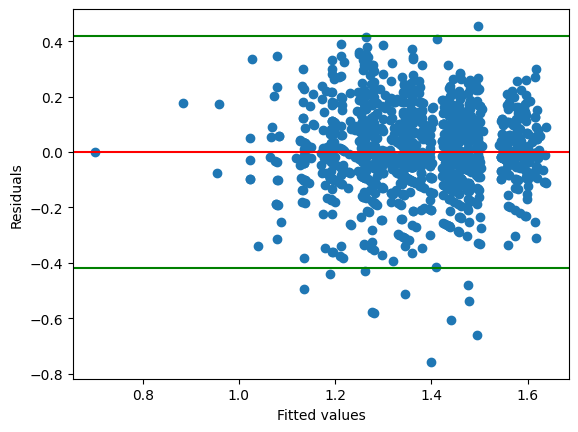

In [25]:
## Wykresy rozrzutu reszt (z liniami 0 oraz ±3*std)
plt.scatter(reg_2.fittedvalues, reg_2.resid)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.scatter(reg_2.fittedvalues, reg_2.resid)
plt.axhline(y=0, color='red')
plt.axhline(y=3*reg_2.resid.std(), color='green')
plt.axhline(y=-3*reg_2.resid.std(), color='green')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [26]:
## Model regresji odporny na heteroskedastyczność (macierz HC0)
robust_reg_3 = smf.ols(formula=formula_poly, data=model3).fit(cov_type='HC0')
print(robust_reg_3.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(log_wydatki)   R-squared:                       0.476
Model:                             OLS   Adj. R-squared:                  0.471
Method:                  Least Squares   F-statistic:                     124.7
Date:                 Mon, 14 Apr 2025   Prob (F-statistic):          1.33e-212
Time:                         00:22:36   Log-Likelihood:                 795.43
No. Observations:                 1448   AIC:                            -1565.
Df Residuals:                     1435   BIC:                            -1496.
Df Model:                           12                                         
Covariance Type:                   HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [27]:
## Test reset dla modelu robust_reg_3
robust_reset = sms.linear_reset(robust_reg_3, power=4, test_type='fitted')
print("Reset test dla robust_reg_3:", robust_reset)

Reset test dla robust_reg_3: <Wald test (chi2): statistic=2.709230115482246, p-value=0.43866101119002265, df_denom=3>


In [28]:
## Obliczanie współczynników VIF
y, X = patsy.dmatrices(formula_poly, data=model3, return_type='dataframe')
vif_data = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif_data)

               Variable         VIF
0             Intercept  117.443363
1    np.log(dochod_los)    1.091320
2                wyzsze    3.405212
3               srednie    3.111109
4         powyzej500tys    1.383554
5            od200do499    1.143288
6            od100do199    1.108817
7              od20do99    1.236577
8             ponizej20    1.158111
9           liczba_osob   54.605851
10  I(liczba_osob ** 2)  183.196819
11  I(liczba_osob ** 3)   52.365797
12          inwalidztwo    1.071311


Jarque-Bera stat: 275.0679451695213, p-value: 1.861035391386616e-60


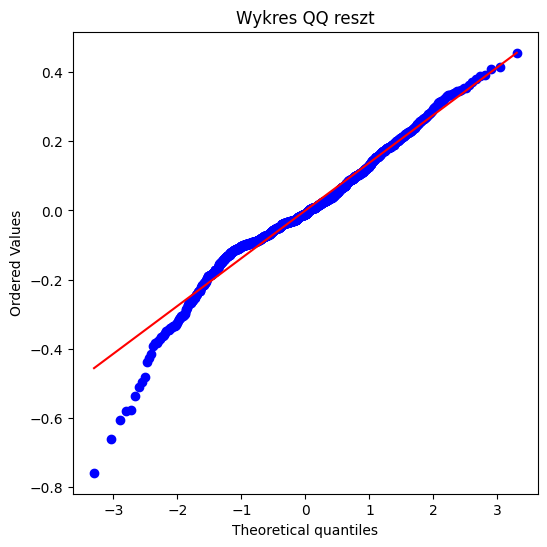

In [29]:
residuals_jb = robust_reg_3.resid
jb_stat, jb_p = jarque_bera(residuals_jb)
print(f"Jarque-Bera stat: {jb_stat}, p-value: {jb_p}")

plt.figure(figsize=(6,6))
stats.probplot(residuals_jb, dist='norm', plot=plt)
plt.title('Wykres QQ reszt')
plt.show()


# Analiza normalności

Definiujemy funkcję wykonującą testy normalności (Anderson-Darling i D'Agostino-Pearsona) i stosujemy ją do kolumny 'wyd_os_lek'.

In [30]:
def perform_normality_tests(series):
    """
    Wykonuje testy normalności: Andersona-Darlinga oraz D'Agostino-Pearsona.
    """
    values = series.dropna()
    if len(values) < 3:
        return None

    ad_result = anderson(values)
    stat_np, p_np = normaltest(values)

    return {
        'anderson_statistic': ad_result.statistic,
        'anderson_critical_values': ad_result.critical_values,
        'anderson_significance_levels': ad_result.significance_level,
        'dagostino_statistic': stat_np,
        'dagostino_pvalue': p_np
    }

# Wczytanie danych ponownie (upewnij się, że ścieżka jest poprawna)
data = pd.read_excel("Model_Lekarz.xlsx")
column_to_test = "wyd_os_lek"
results = perform_normality_tests(data[column_to_test])

print("Wyniki testu Andersona-Darlinga:")
print(f"Statystyka: {results['anderson_statistic']:.4f}")
print("Krytyczne wartości i poziomy istotności:")
for crit_val, sig_level in zip(results['anderson_critical_values'], results['anderson_significance_levels']):
    print(f"   Poziom istotności {sig_level}%: {crit_val:.4f}")

print("\nWyniki testu D'Agostino-Pearsona:")
print(f"Statystyka: {results['dagostino_statistic']:.4f}")
print(f"P-value: {results['dagostino_pvalue']:.4f}")

if results['dagostino_pvalue'] > 0.05:
    print("\nD'Agostino-Pearsona: Dane są zgodne z rozkładem normalnym.")
else:
    print("\nD'Agostino-Pearsona: Dane nie są zgodne z rozkładem normalnym.")

Wyniki testu Andersona-Darlinga:
Statystyka: 151.5778
Krytyczne wartości i poziomy istotności:
   Poziom istotności 15.0%: 0.5740
   Poziom istotności 10.0%: 0.6540
   Poziom istotności 5.0%: 0.7850
   Poziom istotności 2.5%: 0.9150
   Poziom istotności 1.0%: 1.0890

Wyniki testu D'Agostino-Pearsona:
Statystyka: 2486.8078
P-value: 0.0000

D'Agostino-Pearsona: Dane nie są zgodne z rozkładem normalnym.


# Wnioski i rekomendacje

Podsumowujemy wyniki analizy i modelowania. Zachęcamy do dalszej analizy wpływu poszczególnych zmiennych oraz rozważenia ewentualnych modyfikacji modelu.